In [198]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize


In [553]:
CURR_SOFR_FIX = 0.0455
FIX_DATE = dt.date(2023, 3, 2)


# Added additional jump date in october in addition to FOMC dates
fomc_dates = [
    dt.date(2023, 3, 23),
    dt.date(2023, 5, 4),
    dt.date(2023, 6, 15),
    dt.date(2023, 7, 27),
    dt.date(2023, 9, 21),
    dt.date(2023, 10, 1),
    dt.date(2023, 11, 2),
    dt.date(2023, 12, 14),
    dt.date(2023, 12, 31),
    dt.date(2024, 1, 26),
    dt.date(2024, 3, 23)
    ]

fomc_dates = [pd.to_datetime(x) for x in fomc_dates]

start_steps = [25] * len(fomc_dates)

class SOFR1:
    pass


In [554]:
class CurveSOFR:

    def __init__(self, sofr_fixings: pd.DataFrame):
        
        self.fixings = sofr_fixings.copy()
        self.current_date = self.fixings.index[-1]
        self.current_fix = self.fixings.iloc[-1,0]

    def bootstrap_from_futures(self, fomc_dates: list, future_obj_list: list):
        
        # Not implemented for SOFR3 futures yets
        for future in future_obj_list:
            print(f'Bootstrapping rates for SOFR 1M future ending on {future.contract_end}')
            self.bootstrap_single_rate(fomc_dates, future)


    def bootstrap_single_rate(self, fomc_dates: list, future_obj: SOFR1):
        
        start_date = future_obj.contract_start
        end_date = future_obj.contract_end
        next_fomc = min(fomc_dates, key=lambda sub: (sub - start_date) < dt.timedelta(0))
        
        # Check whether next FOMC meeting falls within contract month, if not, skip
        if next_fomc > end_date:
            return None

        days_to_fomc = (next_fomc - start_date).days
        days_from_fomc = (end_date - next_fomc).days + 1
        days_in_contract = (end_date - start_date).days + 1

        if start_date in self.fixings.index:
            fix_idx = start_date
        else:
            fix_idx = self.fixings.index[-1]

        observed = self.fixings[fix_idx:]

        r_boot = future_obj.bootstrap_rate_from_px(observed, days_in_contract, days_to_fomc, days_from_fomc)

        self.fixings.loc[next_fomc, 'rate'] = r_boot

        return r_boot

    def fill_curve_gaps(self):

         self.fixings = self.fixings.resample('D').mean().ffill()

    def fit_curve_to_instruments(self, futures: list, fomc_dates: list):
        
        prices = np.array([f.price for f in futures])
        steps = np.array([25] * len(fomc_dates))

        def target(steps, current_fix, fomc_dates, instruments):
            
            instrument_dates = [i.contract_end for i in instruments]
            date_range = pd.date_range(instrument_dates[0], instrument_dates[-1])
            constructed_curve = pd.DataFrame(index = pd.DatetimeIndex(fomc_dates), data = {'rate': current_fix, 'steps': steps})
            constructed_curve['cumu_steps'] = constructed_curve['steps'].cumsum() / 10000
            constructed_curve['rate'] = constructed_curve['rate'] + constructed_curve['cumu_steps']
            constructed_curve.loc[self.current_date, 'rate'] = current_fix
            constructed_curve = constructed_curve.resample('D').mean()
            constructed_curve = constructed_curve.ffill()

            market_prices = np.array([i.price for i in futures])
            implied_prices = np.array([i.price_from_curve(constructed_curve[['rate']]) for i in futures])

            e = sum((market_prices - implied_prices)**2)

            print(market_prices, implied_prices)

            return e

        results = minimize(target, steps, args=(self.current_fix, fomc_dates, futures), method = 'SLSQP')

        print(results)

class Futures:

    def __init__(self, contract_start: dt.date, price: float = None):

        self.contract_start = contract_start
        self.eval_date = None
        self.price = price

    @property
    def implied_rate(self):

        if self.price is None:
            print(f'Warning: price needed to calculate implied rate')
        else:
            return (100 - self.price) / 100

class FuturesSOFR1M(Futures):

    @property
    def contract_end(self):
        
        contract_end = pd.to_datetime(dt.date(
        self.contract_start.year + self.contract_start.month // 12, 
        self.contract_start.month % 12 + 1, 1
        ) - dt.timedelta(1))

        return contract_end

    def price_from_curve(self, curve_fixings: pd.DataFrame):
        
        days_in_contract = (self.contract_end - self.contract_start).days + 1
        r = np.sum(curve_fixings.loc[self.contract_start:self.contract_end,'rate']) / days_in_contract

        px = 100 - r * 100

        self.price = px
        
        return px

    def bootstrap_rate_from_px(self, observed: pd.DataFrame, days_in_contract: int, days_to_fomc: int, days_from_fomc: int):

        r_obs = np.sum(observed.rate) / len(observed)

        r_boot = (self.implied_rate * days_in_contract - r_obs * days_to_fomc) / days_from_fomc

        return r_boot


class FuturesSOFR3M(Futures):

    @property
    def contract_end(self):
        # End 1 day before third wednesday of third month
        contract_end = pd.date_range(
            self.contract_start, self.contract_start + 
            pd.DateOffset(months = 3) + 
            pd.offsets.MonthEnd(1), 
            freq='WOM-3WED')[-1] + pd.DateOffset(days = -1)

        return contract_end

    def bootstrap_rate_from_px(self, observed: pd.DataFrame, days_in_contract: int, days_to_fomc: int, days_from_fomc: int):

        days_from_start = days_in_contract - days_from_fomc - days_to_fomc

        r_obs = np.prod(1 + observed.rate / 360) 

        r_numerator = (1 + self.implied_rate * days_in_contract / 360)
        r_average_obs = (np.prod(1 + observed.rate / 360) - 1) * 360 / len(observed)
        r_denominator = (1 + r_average_obs / 360) ** (days_from_start + days_to_fomc)
        r_boot = ((r_numerator / r_denominator) ** (1 / days_from_fomc) - 1) * 360

        return r_boot


In [555]:
def load_fixings():
    sofr_fixings = pd.read_csv("sofr_fixings.csv").iloc[:-1,[0,2]]
    sofr_fixings.columns = ['date','rate']
    sofr_fixings.rate = sofr_fixings.rate / 100
    sofr_fixings.date = sofr_fixings.date.apply(lambda x: dt.datetime.strptime(x,"%m/%d/%Y").date())
    sofr_fixings.set_index('date', inplace=True)
    sofr_fixings = sofr_fixings.sort_index()
    sofr_fixings.index = pd.to_datetime(sofr_fixings.index)
    sofr_fixings = sofr_fixings.resample('D').mean().ffill()
    return sofr_fixings

sofr_fixings = load_fixings()

In [556]:
sofr = CurveSOFR(sofr_fixings)
sofr_1m = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 3, 1)), 95.365)
sofr_3m = FuturesSOFR3M(pd.to_datetime(dt.date(2023, 1, 18)), 95.3725)

# sofr.bootstrap_single_rate(fomc_dates, sofr_3m)

In [557]:
SOFR = CurveSOFR(sofr_fixings)

dates = [pd.to_datetime(dt.date(2023, 3, 1)),
        pd.to_datetime(dt.date(2023, 4, 1)),
        pd.to_datetime(dt.date(2023, 5, 1)),
        pd.to_datetime(dt.date(2023, 6, 1)),
        pd.to_datetime(dt.date(2023, 7, 1)),
        pd.to_datetime(dt.date(2023, 8, 1)),
        pd.to_datetime(dt.date(2023, 9, 1)),
        pd.to_datetime(dt.date(2023, 10, 1)),
        pd.to_datetime(dt.date(2023, 11, 1)),
        pd.to_datetime(dt.date(2023, 12, 1)),
        pd.to_datetime(dt.date(2024, 1, 1)),
        pd.to_datetime(dt.date(2024, 2, 1))]
        
prices = [
    95.3625,
    95.14,
    94.885,
    94.765,
    94.67,
    94.59,
    94.575,
    94.57,
    94.62,
    94.66,
    94.69,
    94.77
    ]


future1 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 3, 1)), 95.3625)
future2 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 4, 1)), 95.14)
future3 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 5, 1)), 94.885)
future4 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 6, 1)), 94.765)
future5 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 7, 1)), 94.67)
future6 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 8, 1)), 94.59)
future7 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 9, 1)), 94.575)
future8 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 10, 1)), 94.57)
future9 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 11, 1)), 94.62)
future10 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 12, 1)), 94.66)
future11 = FuturesSOFR1M(pd.to_datetime(dt.date(2024, 1, 1)), 94.69)
future12 = FuturesSOFR1M(pd.to_datetime(dt.date(2024, 2, 1)), 94.77)

futures_list = [future1, future2, future3, future4, future5, future6, future7, future8, future9, future10, future11, future12]

Bootstrapping rates for SOFR 1M future ending on 2023-03-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-04-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-05-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-06-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-07-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-08-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-09-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-10-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-11-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-12-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2024-01-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2024-02-29 00:00:00


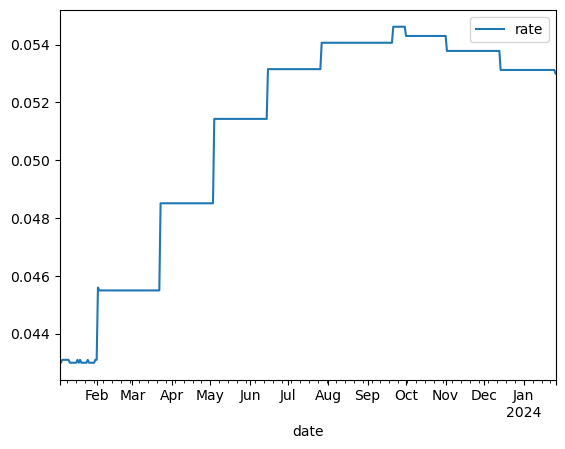

In [558]:
SOFR.bootstrap_from_futures(fomc_dates, futures_list)
SOFR.fill_curve_gaps()
SOFR.fixings.plot()


In [559]:
prices_priced = [f.price_from_curve(SOFR.fixings) for f in futures_list]
pricing_error = np.array(prices) - np.array(prices_priced)

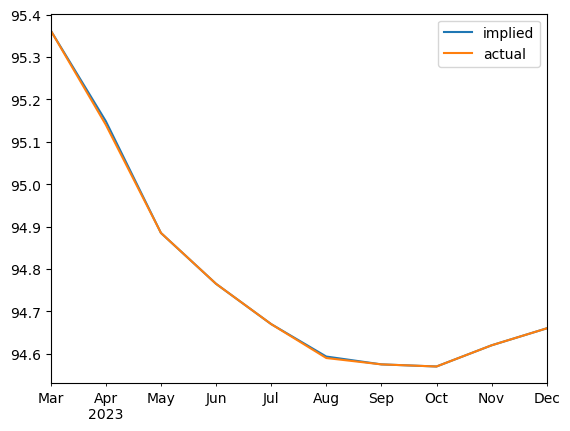

In [560]:
price_df = pd.DataFrame(index = pd.DatetimeIndex(dates), data = {'implied': prices_priced, 'actual': prices})

price_df.iloc[:-2].plot()

In [506]:
SOFR.fixings.to_csv('output.csv')